Diego Silva
Pablo ibañez

importar todas las bibliotecas clave. carga torch, datasets (para los datos), y lo esencial de transformers (whisperprocessor, whisperforconditionalgeneration, trainer) para construir y entrenar el modelo. tambien importa evaluate para medir los resultados.

In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
from datasets import load_dataset, concatenate_datasets, DatasetDict
from datasets import Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import TrainingArguments
from transformers import Trainer
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import librosa  
import seaborn as sns
from transformers import WhisperForConditionalGeneration

se verifica si una gpu (cuda) esta disponible con torch.cuda.is_available(). si la respuesta es afirmativa, imprime el nombre de la gpu. si es negativa, informa que no se detecto una gpu. esto confirma si se usara aceleracion por hardware.

In [3]:
# Verificar si CUDA esta disponible
cuda_disponible = torch.cuda.is_available()
print(f"CUDA disponible: {cuda_disponible}")

if cuda_disponible:
    # Obtener el nombre de la GPU
    nombre_gpu = torch.cuda.get_device_name(0)
    print(f"Nombre de la GPU detectada: {nombre_gpu}")
else:
    print("PyTorch no detectó una GPU compatible con CUDA.")

CUDA disponible: True
Nombre de la GPU detectada: NVIDIA GeForce RTX 4060


## Carga y Division del Dataset

se cargan dos subconjuntos del dataset "google-chilean-spanish", uno de voces femeninas y otro de masculinas, usando load_dataset. despues, se combinan ambos en un unico dataset con concatenate_datasets. finalmente, este dataset combinado se divide en dos partes usando train_test_split: un 80% para "train" (entrenamiento) y un 20% para "test" (prueba). el print muestra la estructura final de este datasetdict dividido.

In [4]:
dataset_female = load_dataset("ylacombe/google-chilean-spanish", "female")
dataset_male = load_dataset("ylacombe/google-chilean-spanish", "male")

# Combinar los datos de los dos dataset en un unico dataset
combined_dataset = concatenate_datasets([dataset_female['train'], dataset_male['train']])

# Dividir conjunto 
dataset_splits = combined_dataset.train_test_split(test_size=0.2)
dataset = dataset_splits
print(dataset)

Parameter 'generator'=Generator(PCG64) of the transform datasets.arrow_dataset.Dataset.train_test_split couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'speaker_id'],
        num_rows: 3499
    })
    test: Dataset({
        features: ['audio', 'text', 'speaker_id'],
        num_rows: 875
    })
})


## Preprocesamiento del Texto con impieza y normalizacion

se imprime el texto de un ejemplo "antes" de ser procesado. se define una funcion preparar_texto que convierte el texto a minusculas y elimina caracteres de puntuacion. luego, se aplica esta funcion a todos los elementos del dataset usando .map(). al final, se imprime el texto del mismo ejemplo "despues" para mostrar el resultado de la limpieza.

In [5]:
print("Antes")
print(dataset['train'][0]['text'])

# Funcion para limpiar y normalizar el texto
def preparar_texto(batch):
    # Convertir a minusculas
    texto_limpio = batch['text'].lower()
    # Eliminar puntuacion básica 
    caracteres_a_eliminar = ".,?!¡¿"
    for char in caracteres_a_eliminar:
        texto_limpio = texto_limpio.replace(char, '')
    
    batch['text'] = texto_limpio
    return batch

dataset = dataset.map(preparar_texto)

print("Despues")
print(dataset['train'][0]['text'])

Antes
¿Cómo podria aprender Chino en una semana?


Map:   0%|          | 0/3499 [00:00<?, ? examples/s]

Map:   0%|          | 0/875 [00:00<?, ? examples/s]

Despues
cómo podria aprender chino en una semana


## preprocesamiento del Audio con Remuestreo a 16kHz

se modifica la columna "audio" de todo el dataset usando cast_column. esto hace que, al cargar cualquier audio, se remuestree automaticamente a 16000 hz (16khz). luego, se imprime un mensaje de confirmacion y se verifica el cambio, imprimiendo la nueva frecuencia de muestreo del primer audio del set de entrenamiento.

In [6]:
# al audio lo remuestree automaticamente a 16kHz.
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
print("Dataset remuestreado a 16kHz")
# Verificación 
print(f"Nueva frecuencia de muestreo: {dataset['train'][0]['audio']['sampling_rate']} Hz")

Dataset remuestreado a 16kHz
Nueva frecuencia de muestreo: 16000 Hz


## Carga del Modelo Pre-entrenado 

se define la variable model_name con el texto "openai/whisper-tiny". primero, se descarga y carga el whisperprocessor (que prepara el audio y el texto) correspondiente a ese modelo. despues, se descarga y carga el modelo pre-entrenado whisperforconditionalgeneration (la arquitectura con los pesos) usando el mismo nombre. los print anuncian el inicio de cada carga.

In [7]:
MODEL_NAME = "openai/whisper-tiny" # version tiny del modelo

print(f"Cargando el procesador para {MODEL_NAME}")
processor = WhisperProcessor.from_pretrained(MODEL_NAME)

print(f"Cargando el modelo pre-entrenado {MODEL_NAME}")
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)

print("Modelo cargado correctamente")

Cargando el procesador para openai/whisper-tiny
Cargando el modelo pre-entrenado openai/whisper-tiny
Modelo cargado correctamente


## procesamiento y Tokenización del Dataset

se define una funcion preparar_dataset_para_modelo que usa el processor para crear las columnas input_features (del audio) y labels (del texto). esta funcion se aplica a todo el dataset con .map(), eliminando las columnas originales. los print muestran la estructura del dataset "antes" y "despues" de esta transformacion.

In [8]:
print("estructura antes del procesamiento")
print(dataset['train'][0])

def preparar_dataset_para_modelo(batch):
    #Cargar y remuestrear el audio
    audio = batch["audio"]

    # Convertir el audio en un espectrograma
    batch["input_features"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # Preparar las etiquetas,el procesador convierte el texto en tokens creando la columna labels
    batch["labels"] = processor(text=batch["text"]).input_ids
    return batch

print("\nProcesando el dataset")

dataset = dataset.map(preparar_dataset_para_modelo, remove_columns=dataset.column_names["train"])

print("\nDataset listo para el entrenamiento")
print("\nestructura despues del entrenamiento")
print(dataset['train'][0])

estructura antes del procesamiento
{'audio': {'path': 'clm_02436_01186774711.wav', 'array': array([ 5.51008561e-05,  2.66890274e-05,  8.36417312e-05, ...,
       -6.18025893e-04, -4.44498903e-04, -5.60190063e-04], shape=(45056,)), 'sampling_rate': 16000}, 'text': 'cómo podria aprender chino en una semana', 'speaker_id': 2436}

Procesando el dataset


Map:   0%|          | 0/3499 [00:00<?, ? examples/s]

Map:   0%|          | 0/875 [00:00<?, ? examples/s]


Dataset listo para el entrenamiento

estructura despues del entrenamiento
{'input_features': [[-0.2300877571105957, -0.2357701063156128, -0.26093292236328125, -0.19645869731903076, -0.2680729627609253, -0.3323448896408081, -0.38151276111602783, -0.39181220531463623, -0.2991318702697754, -0.18556177616119385, -0.10078716278076172, -0.33177614212036133, -0.3963867425918579, -0.3143284320831299, -0.19813787937164307, -0.14285790920257568, -0.17341947555541992, -0.13744068145751953, -0.07972157001495361, -0.031871676445007324, 0.030535101890563965, -0.11271190643310547, -0.12969434261322021, -0.1674290895462036, -0.17455530166625977, -0.24190425872802734, -0.331524133682251, -0.27167797088623047, -0.38651609420776367, -0.46462762355804443, -0.7948898077011108, -0.6122294664382935, -0.7948898077011108, -0.7948898077011108, -0.5464916229248047, -0.666366457939148, -0.19856858253479004, -0.15745019912719727, -0.12683629989624023, -0.18554818630218506, 0.03818398714065552, -0.1678984165191650

## definicion del Data Collator

se define una clase datacollator personalizada para crear los lotes (batches). esta clase toma los input_features (audio) y labels (texto) y usa el processor para aplicarles padding (relleno), asegurando que todos tengan el mismo tamano dentro del lote.

lo mas importante es que, despues de rellenar los labels, reemplaza los tokens de padding por -100. esto es un paso crucial para que el modelo ignore esos tokens al calcular el error (loss) durante el entrenamiento. al final, se crea una instancia de esta clase.

In [9]:
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    """
    Clase que toma los 'input_features' y 'labels' del dataset
    y los agrupa en lotes (batches) con padding.
    """
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Separar los espectrogramas  y las etiquetas 
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # Aplicar padding a los espectrogramas
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Aplicar padding a las etiquetas 
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # El padding en las etiquetas debe ser -100 para que el modelo lo ignore en el cálculo de la pérdida (loss)
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # No queremos que el modelo prediga el token de inicio, así que lo quitamos si existe
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

# Inicializar el Data Collator
print("Creando el Data Collator...")
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)
print("Data Collator listo")

Creando el Data Collator...
Data Collator listo


## definicion de los parametros de entrenamiento

se crea la configuracion para el trainer usando trainingarguments. se define el directorio donde se guardara el modelo (output_dir), el tamano del lote (batch_size de 4) y los pasos de acumulacion de gradiente (2).

lo mas importante es que se ajusta la estrategia: se desactiva la evaluacion durante el entrenamiento (eval_strategy="no") y se establece que el modelo se guarde al final de cada epoca (save_strategy="epoch"). ademas, se activa fp16 (mixed precision) para usar la gpu de forma mas eficiente.

In [ ]:
BATCH_SIZE = 4 # Un BATCH_SIZE de 4 

training_args = TrainingArguments(
    output_dir="./whisper-tiny-chilean",
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    learning_rate=1e-5,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=25,
    
    # Apagamos la evaluación durante el entrenamiento para evitar un bug que provoca un error al entrenar
    eval_strategy="epoch", #eval_strategy="no"  o tambien eval_strategy="epoch",
    save_strategy="epoch", # Guardaremos el modelo al final de cada época 
    
    load_best_model_at_end=True, # No se puede cargar el mejor si no evalua load_best_model_at_end=False,
    metric_for_best_model="eval_loss", # desactivar si falla metric_for_best_model="eval_loss" o metric_for_best_model="eval_wer"
    greater_is_better=False, #desactivar si falla
    fp16=True # si la gpu está activa

    # early_stopping_patience=2,
)

print("Argumentos de entrenamiento definidos")

Argumentos de entrenamiento definidos


## definicipn de la metrica de evaluacion WER

se carga la metrica "wer" usando evaluate.load(). despues, se define la funcion compute_metrics. esta funcion toma las predicciones del modelo (pred), convierte los logits a texto usando np.argmax, limpia los label_ids (reemplazando -100), y decodifica ambos. finalmente, calcula el "wer" comparando los textos y devuelve el resultado.

In [11]:
# Cargar la metrica WER de Hugging Face
print("Cargando la metrica WER...")
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    # Esta es la versión que sabe manejar los logits
    logits = pred.predictions[0] # cambiar a este si falla logits = pred.predictions ;logits = pred.predictions[0]
    label_ids = pred.label_ids

    pred_ids = np.argmax(logits, axis=-1)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"wer": wer}

print("Funcion para calcular métricas (WER) lista ")

Cargando la metrica WER...
Funcion para calcular métricas (WER) lista 


## inicializacion y Ejecucion del Entrenamiento

se imprime el tamano original del "test" set. luego, se crea un nuevo dataset llamado small_eval_dataset que contiene unicamente los primeros 50 audios del set de prueba, usando .select(range(50)). esto se hace para reducir el uso de ram durante la evaluacion. finalmente, se imprime el tamano del nuevo set reducido (50).

In [12]:
#Crear un set de evaluacion más pequeño por limitacion de ram
print(f"Set de evaluacion original: {len(dataset['test'])} audios")
small_eval_dataset = dataset["test"].select(range(50)) # Tomamos solo los primeros 50 audios
print(f"Nuevo set de evaluacion reducido: {len(small_eval_dataset)} audios")

Set de evaluacion original: 875 audios
Nuevo set de evaluacion reducido: 50 audios


se inicializa el objeto trainer con los componentes principales: el model, los training_args (la configuracion), el train_dataset (datos de entrenamiento) y el data_collator. se omiten los argumentos de evaluacion, acorde a la configuracion. despues, se imprime un mensaje de inicio y se ejecuta trainer.train() para comenzar el proceso de fine-tuning. un mensaje final avisa cuando el entrenamiento termina.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=small_eval_dataset, # desactivar si falla
    compute_metrics=compute_metrics, # desactivar si falla
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)

print("\nIniciando el entrenamiento")
print("El modelo se entrenará y se guardara al final de cada epoca")

trainer.train()

print("\nEntrenamiento completado")

C:\Users\diego\AppData\Local\Temp\ipykernel_45916\1355910698.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Iniciando el entrenamiento
El modelo se entrenará y se guardara al final de cada epoca


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
d:\Anaconda\envs\whisper_env\lib\site-packages\transformers\integrations\sdpa_attention.py:96: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


d:\Anaconda\envs\whisper_env\lib\site-packages\transformers\modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].



Entrenamiento completado


In [14]:
print("guardando el mejor modelo en una carpeta final...")
trainer.save_model("./whisper_tiny_chileno_final")
print(" modelo guardado en la carpeta: './whisper_tiny_chileno_final'")

guardando el mejor modelo en una carpeta final...
 modelo guardado en la carpeta: './whisper_tiny_chileno_final'


se inicia la evaluacion manual. se utiliza el metodo trainer.predict() sobre el small_eval_dataset (el de 50 audios) para obtener las predicciones del modelo. al terminar, se imprimen las metricas resultantes de esta evaluacion (guardadas en results.metrics), que mostraran el rendimiento, como el 'eval_wer'.

In [15]:
print("\nIniciando Evaluación Manual")

# Usamos nuestro set de evaluacion reducido
results = trainer.predict(small_eval_dataset, metric_key_prefix="eval")

print("\nEvaluación Manual Completada")
print("Metricas del modelo entrenado")
print(results.metrics)


Iniciando Evaluación Manual



Evaluación Manual Completada
Metricas del modelo entrenado
{'eval_loss': 0.18615172803401947, 'eval_wer': 0.1836283185840708, 'eval_runtime': 5.625, 'eval_samples_per_second': 8.889, 'eval_steps_per_second': 1.244}


se carga el whisperprocessor (de "openai/whisper-tiny") y el modelo whisperforconditionalgeneration entrenado localmente (desde "checkpoint-3942"). el modelo se envia a la gpu ("cuda").

luego, se carga una muestra de audio nueva (ejemplo 10) del dataset_female, remuestreandola a 16khz. el processor convierte este audio en input_features y se envia a la gpu. se usa model.generate() para predecir el texto.

finalmente, se imprime el texto original de la muestra y la transcripcion generada por el modelo para compararlos.

In [16]:
print("Cargando modelo")

# Cargamos el procesador
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")

# Cargamos el modelo que entranado desde la carpeta local
model = WhisperForConditionalGeneration.from_pretrained("./whisper_tiny_chileno_final") #"D:\U\deep learning\Proyecto semestral\whisper_tiny_chileno_final"

# Mover el modelo a la GPU  para que sea rápido
if torch.cuda.is_available():
    model.to("cuda")

print("Modelo 'whisper-tiny-chilean' desde checkpoint cargado")

print("Cargando un audio de prueba")

# Accedemos a "train" que y lo remuestreamos 
test_sample_source = dataset_female["train"].cast_column("audio", Audio(sampling_rate=16000))
sample = test_sample_source[10] 

# Preparar el audio 
audio = sample["audio"]
input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features

# Mover el audio a la GPU
if torch.cuda.is_available():
    input_features = input_features.to("cuda")

print("\nGenerando transcripcion")

#Generar la transcripcion
predicted_ids = model.generate(input_features, num_beams=5) #predicted_ids = model.generate(input_features) ; predicted_ids = model.generate(input_features, num_beams=5)

# Decodificar la prediccion
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

print(f"\nAudio original de referencia")
print(f"   {sample['text']}")
print(f"\nmodelo predijo ")
print(f"   {transcription[0]}")

Cargando modelo


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


Modelo 'whisper-tiny-chilean' desde checkpoint cargado
Cargando un audio de prueba

Generando transcripcion


`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. If this is not desired, please set these values explicitly.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
A custom logits processor of type <class 'transformers.ge


Audio original de referencia
   Tengo esta imagen en la cabeza que es un mural medio futurista

modelo predijo 
   tengo esta imagen en la cabeza que es un mural medio futurista


se importa librosa para cargar un archivo de audio externo (definido en nombre_de_tu_archivo). la funcion librosa.load carga el audio y lo remuestrea automaticamente a 16khz.
luego, el processor convierte ese audio en input_features (que se mueven a la gpu). se usa model.generate() para obtener los ids predichos y processor.batch_decode() para convertirlos en texto.
finalmente, se imprime la transcripcion resultante. el bloque try...except maneja errores si no se encuentra el archivo.

In [ ]:

NOMBRE_DE_TU_ARCHIVO = r"poner ruta del audio" #r"D:\U\deep learning\Proyecto semestral\corxea.mp3"

print(f"Cargando el archivo: {NOMBRE_DE_TU_ARCHIVO}...")

try:
    # Cargar y Remuestrear el Audio 
    speech_array, sampling_rate = librosa.load(NOMBRE_DE_TU_ARCHIVO, sr=16000)

    # Procesar el Audio 
    input_features = processor(speech_array, sampling_rate=sampling_rate, return_tensors="pt").input_features

    # Mover los datos a la GPU 
    if torch.cuda.is_available():
        input_features = input_features.to("cuda")

    print("Generando transcripcion")

    # Generar la Transcripcion
    predicted_ids = model.generate(input_features, num_beams=5)   #predicted_ids = model.generate(input_features) ; predicted_ids = model.generate(input_features, num_beams=5)

    # Decodificar y Mostrar 
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)

    print("Transcipsion finalizada")
    print(f"\nel modelo predijo")
    print(f"   {transcription[0]}")

except FileNotFoundError:
    print(f"\nERROR ")
    print(f"No se encontró el archivo '{NOMBRE_DE_TU_ARCHIVO}'.")
    print("Asegúrate de que el nombre esté bien escrito y que el archivo esté en la misma carpeta que el notebook.")
except Exception as e:
    print(f"\nOcurrió un error inesperado: {e}")

Cargando el archivo: D:\U\deep learning\Proyecto semestral\corxea.mp3...
Generando transcripcion
Transcipsion finalizada

el modelo predijo
    a partir de ahora me voy en vuelga de ámbre con chitu madre así es vuelga de ámbre loco no voy a comer nada aloco no voy a comer nada hasta que río tiempo no te que es rico el queso azul en mano oan el queso azul en la una agua más rica es que con un poquito a pan


realiza una inferencia completa para generar una visualización de Inteligencia Artificial Explicable (XAI): un mapa de calor que muestra exactamente qué fragmento de audio utilizó el modelo para decidir cada palabra de la transcripción final.

--- Reparando modelo para visualización (Activando Modo Eager) ---
Guardando estado actual del modelo...
Recargando modelo en modo explicativo (esto puede tardar unos segundos)...
--- Generando Mapa de Atención para: D:\U\deep learning\Proyecto semestral\corxea.mp3 ---


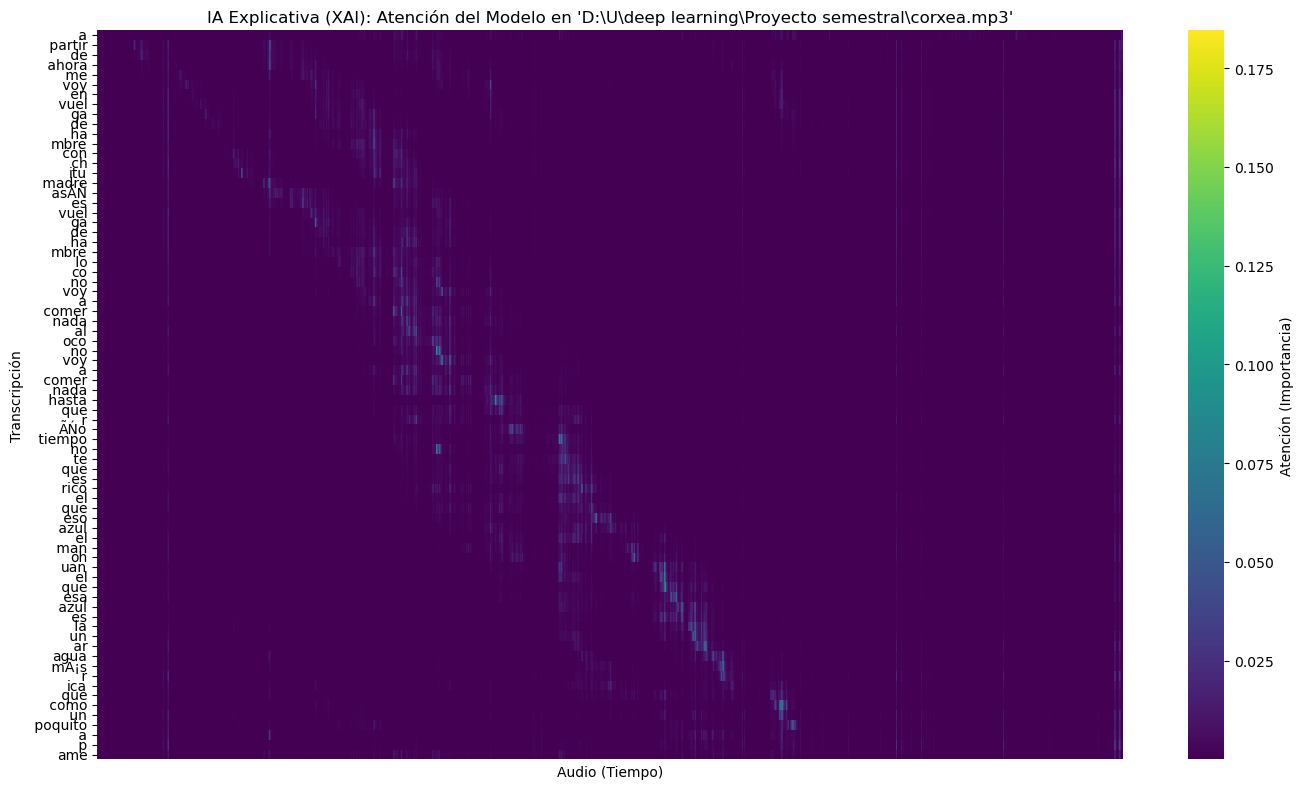

✅ ¡Éxito! Ahora puedes ver qué escuchó el modelo para cada palabra.


In [ ]:

print("Reparando modelo para visualizacion (Modo Eager)")

print("Guardando estado actual del modelo...")
trainer.save_model("./whisper_tiny_chileno_final")

# Cargar el modelo forzando la atención explicita (eager)
print("Recargando modelo en modo explicativo (esto puede tardar unos segundos)...")
model = WhisperForConditionalGeneration.from_pretrained(
    "./whisper_tiny_chileno_final", 
    attn_implementation="eager" 
)
model.to("cuda" if torch.cuda.is_available() else "cpu")

# VISUALIZAR Grad-CAM / Atencion
print(f"--- Generando Mapa de Atención para: {NOMBRE_DE_TU_ARCHIVO} ---")

# Cargar audio
try:
    speech_array, sampling_rate = librosa.load(NOMBRE_DE_TU_ARCHIVO, sr=16000)
except NameError:
    # Ruta de respaldo si la variable se perdió
    NOMBRE_DE_TU_ARCHIVO = r"poner ruta aqui"  #r"D:\U\deep learning\Proyecto semestral\corxea.mp3" 
    speech_array, sampling_rate = librosa.load(NOMBRE_DE_TU_ARCHIVO, sr=16000)

# Procesar
input_features = processor(speech_array, sampling_rate=sampling_rate, return_tensors="pt").input_features.to(model.device)

# Generar predicción y atenciones
model.eval()
with torch.no_grad():
    # Generar los tokens (transcripción)
    predicted_ids = model.generate(input_features)
    
    # Forzar al modelo a devolver las atenciones usando los tokens generados
    outputs = model(
        input_features=input_features,
        decoder_input_ids=predicted_ids,
        output_attentions=True
    )

# Extraer la matriz de atención 
cross_attentions = outputs.cross_attentions[-1]
attention_matrix = cross_attentions[0].mean(dim=0).cpu().numpy()

# Ajustar orientación si es necesario
if attention_matrix.shape[0] != len(predicted_ids[0]):
    attention_matrix = attention_matrix.T

# Preparar etiquetas
tokens = processor.tokenizer.convert_ids_to_tokens(predicted_ids[0])
cleaned_tokens = [t.replace('Ġ', ' ').replace('Ċ', '') for t in tokens]

# GRAFICAR
plt.figure(figsize=(14, 8))
sns.heatmap(
    attention_matrix,
    xticklabels=False,
    yticklabels=cleaned_tokens,
    cmap="viridis",
    cbar_kws={'label': 'Atención (Importancia)'}
)

plt.title(f"IA Explicativa (XAI): Atención del Modelo en '{NOMBRE_DE_TU_ARCHIVO}'")
plt.xlabel("Audio (Tiempo)")
plt.ylabel("Transcripción")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


se hace un reporte visual. se toma el modelo y se pone en la gpu. luego, un bucle for itera 20 veces. en cada ciclo, toma un audio, usa model.generate() para predecir el texto, y finalmente imprime una comparacion entre el texto original ("referencia") y el texto generado ("prediccion").

In [ ]:
print("Iniciando prueba con 20 audios")

try:
    # Re-creamos la fuente de audios 
    test_sample_source = dataset_female["train"].cast_column("audio", Audio(sampling_rate=16000))
except NameError:
    print("Error: 'dataset_female' no está definido. Por favor, vuelve a ejecutar la Celda 1.")
    # Detener la ejecución si la variable no existe
    raise

if torch.cuda.is_available():
    model.to("cuda")

for i in range(20): # Probamos los primeros 20 audios
    sample = test_sample_source[i]
    audio = sample["audio"]
    
    # Preparar el audio
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features
    if torch.cuda.is_available():
        input_features = input_features.to("cuda")

    # Generar prediccion
    predicted_ids = model.generate(input_features, num_beams=5)   #predicted_ids = model.generate(input_features) ; predicted_ids = model.generate(input_features, num_beams=5)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    
    print(f"\nMuestra #{i} ")
    print(f"  REFERENCIA: {sample['text']}")
    print(f"  PREDICCIÓN: {transcription}")


Iniciando prueba con 20 audios

Muestra #0 
  REFERENCIA: La vigencia de tu tarjeta es de ocho meses
  PREDICCIÓN:  La vigencia de tu tarjeta es de ocho meses

Muestra #1 
  REFERENCIA: Tranquilo va a estar todo bien
  PREDICCIÓN:  tranquilo va a estar todo bien

Muestra #2 
  REFERENCIA: Me gusta mucho caminar por el campo y tomarle fotos a la naturaleza
  PREDICCIÓN: me gusta mucho caminar por el campo y tomarle fotos a la naturaleza

Muestra #3 
  REFERENCIA: Está muy cansado
  PREDICCIÓN:  esta muy cansado

Muestra #4 
  REFERENCIA: Tú sabes si esta persona ha presentado este tipo de obras artísticas en otros países ?
  PREDICCIÓN:  tu sabes si esta persona ha presentado este tipo de obras artísticas en otros países

Muestra #5 
  REFERENCIA: Verifique su instalación eléctrica
  PREDICCIÓN:  verifique su instalación eléctrica

Muestra #6 
  REFERENCIA: Hay muchas tiendas de ropa en el centro.
  PREDICCIÓN:  hay muchas tiendas de ropa en el centro

Muestra #7 
  REFERENCIA: Últimame

se importa matplotlib.  se usan estas variables para crear un grafico de barras (plt.bar) que compara visualmente el error de entrenamiento con el de evaluacion. se anaden titulos y se usa plt.text para escribir el valor numerico exacto encima de cada barra. plt.show() muestra el grafico final.

--- generando grafica de sobreajuste (loss) automatica ---
valores automaticos encontrados: train loss = 0.0621, eval loss = 0.1862


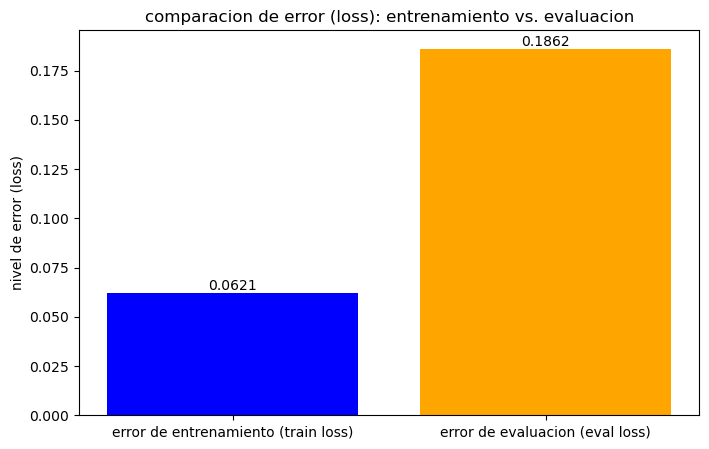

In [ ]:
print("generando grafica de sobreajuste (loss) automatica")

train_loss = 0.0
eval_loss = 0.0

try:
    eval_loss = results.metrics['eval_loss']
except (NameError, KeyError): 
    print("advertencia: no se pudo obtener 'eval_loss' de la variable 'results.metrics'.")
    print("asegurate de haber ejecutado la celda [18] (trainer.predict) primero.")

try:
    train_log = next((log for log in reversed(trainer.state.log_history) if 'loss' in log), None) 
    
    if train_log:
        train_loss = train_log['loss']
    else:
        print("advertencia: no se pudo encontrar 'loss' en 'trainer.state.log_history'.")
        
except NameError: 
    print("advertencia: no se encontro 'trainer.state.log_history'.")
    print("asegurate de haber ejecutado la celda [17] (trainer.train) primero.")

print(f"valores automaticos encontrados: train loss = {train_loss:.4f}, eval loss = {eval_loss:.4f}")

if train_loss == 0.0 and eval_loss == 0.0:
    print("error: no se pudieron obtener los valores de loss. no se puede graficar.")
else:
    labels = ['error de entrenamiento (train loss)', 'error de evaluacion (eval loss)']
    valores = [train_loss, eval_loss]

    plt.figure(figsize=(8, 5))
    barras = plt.bar(labels, valores, color=['blue', 'orange'])
    plt.title('comparacion de error (loss): entrenamiento vs. evaluacion')
    plt.ylabel('nivel de error (loss)')

    for barra in barras:
        yval = barra.get_height()
        plt.text(barra.get_x() + barra.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

    plt.show()

Genera gráficos de línea a partir del historial de logs para visualizar la evolución del aprendizaje. Muestra comparativamente la reducción de la pérdida (loss) en entrenamiento y validación, y traza el descenso del error de palabras (WER) época tras época.

--- generando graficos de lineas del entrenamiento ---
grafico 1: loss


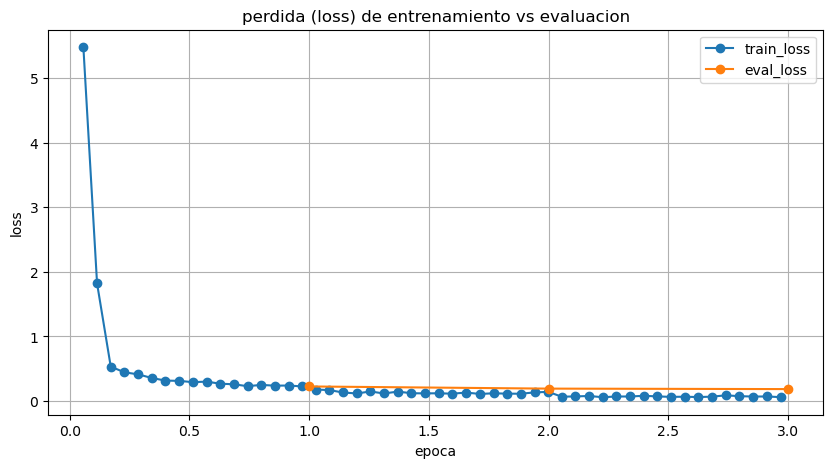

grafico 2: wer


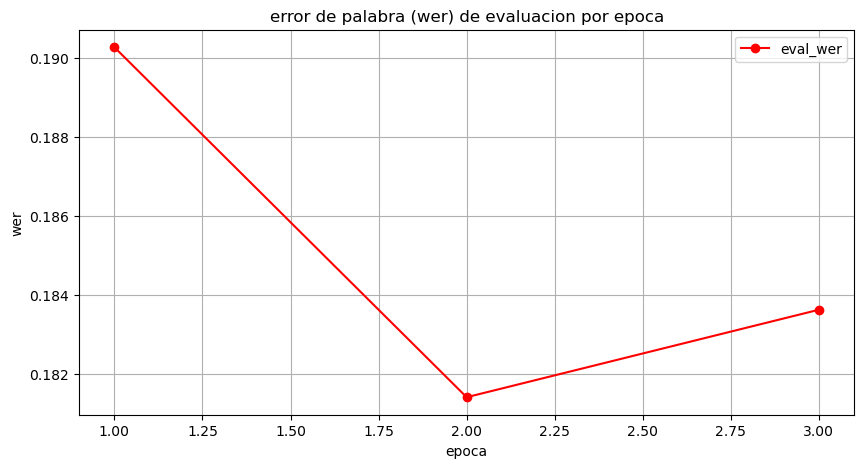

In [ ]:
print("generando graficos de lineas del entrenamiento")

# extraer todo el historial de logs del trainer
history = trainer.state.log_history

# separar los logs de entrenamiento y los de evaluacion
train_logs = [log for log in history if 'loss' in log]
eval_logs = [log for log in history if 'eval_loss' in log]

# sacar los datos para los graficos
train_epochs = [log['epoch'] for log in train_logs]
train_losses = [log['loss'] for log in train_logs]

eval_epochs = [log['epoch'] for log in eval_logs]
eval_losses = [log['eval_loss'] for log in eval_logs]
eval_wers = [log['eval_wer'] for log in eval_logs]

# grafico 1 loss
print("grafico 1: loss")
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_losses, label='train_loss', marker='o')
plt.plot(eval_epochs, eval_losses, label='eval_loss', marker='o')
plt.title('perdida (loss) de entrenamiento vs evaluacion')
plt.xlabel('epoca')
plt.ylabel('loss')
plt.legend()
plt.grid(True) # <-- corregido
plt.show()

# grafico 2 wer
print("grafico 2: wer")
plt.figure(figsize=(10, 5))
plt.plot(eval_epochs, eval_wers, label='eval_wer', marker='o', color='red')
plt.title('error de palabra (wer) de evaluacion por epoca')
plt.xlabel('epoca')
plt.ylabel('wer')
plt.legend()
plt.grid(True) 
plt.show()

Extrae el historial de métricas y calcula una estimación de la precisión (Accuracy) invirtiendo el valor del WER (1 - WER). Luego, genera una visualización compuesta por tres gráficos verticales que muestran la curva de aprendizaje (Perdida), la reducción del error de palabras y la evolución de la precisión, facilitando el análisis del rendimiento global del modelo de un vistazo.

--- Generando Gráficos de Entrenamiento, WER y Accuracy ---


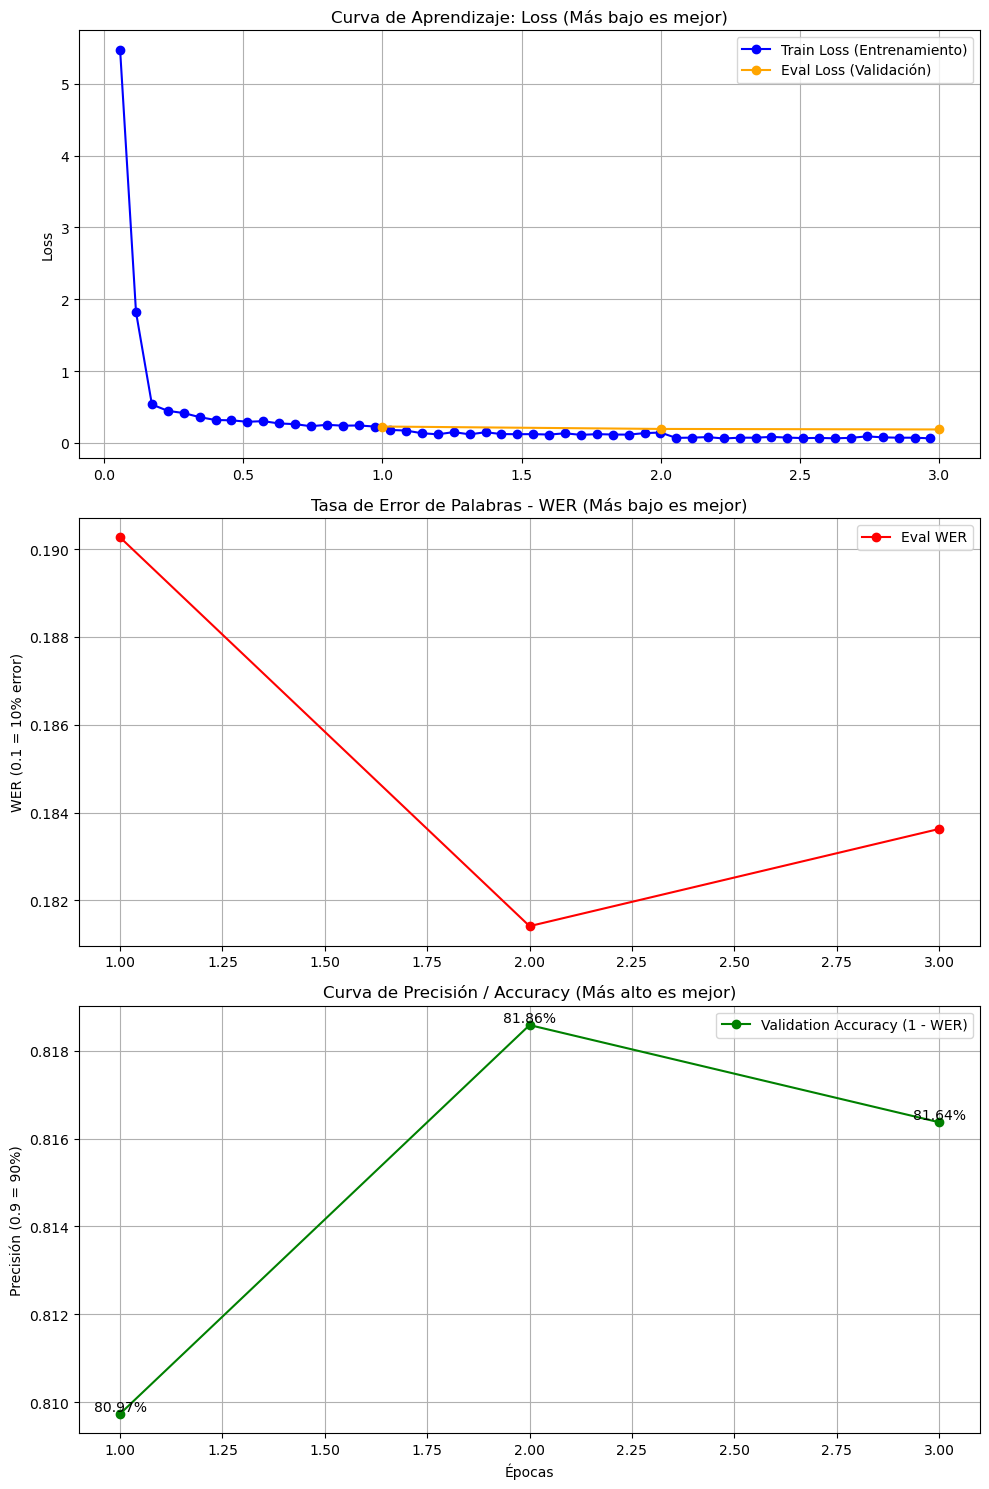

In [ ]:
print("Generando Graficos de Entrenamiento, WER y Accuracy")

history = trainer.state.log_history

train_logs = [log for log in history if 'loss' in log]
eval_logs = [log for log in history if 'eval_loss' in log]

train_epochs = [log['epoch'] for log in train_logs]
train_losses = [log['loss'] for log in train_logs]

eval_epochs = [log['epoch'] for log in eval_logs]
eval_losses = [log['eval_loss'] for log in eval_logs]
eval_wers = [log['eval_wer'] for log in eval_logs]

eval_accuracy = [max(0, 1 - wer) for wer in eval_wers]

fig, axs = plt.subplots(3, 1, figsize=(10, 15)) 

#GRAFICO 1 LOSS 
axs[0].plot(train_epochs, train_losses, label='Train Loss (Entrenamiento)', marker='o', color='blue')
axs[0].plot(eval_epochs, eval_losses, label='Eval Loss (Validación)', marker='o', color='orange')
axs[0].set_title('Curva de Aprendizaje: Loss (Más bajo es mejor)')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

#GRAFICO 2 WER 
axs[1].plot(eval_epochs, eval_wers, label='Eval WER', marker='o', color='red')
axs[1].set_title('Tasa de Error de Palabras - WER (Más bajo es mejor)')
axs[1].set_ylabel('WER (0.1 = 10% error)')
axs[1].legend()
axs[1].grid(True)

# GRAFICO 3 ACCURACY 
axs[2].plot(eval_epochs, eval_accuracy, label='Validation Accuracy (1 - WER)', marker='o', color='green')
axs[2].set_title('Curva de Precisión / Accuracy (Más alto es mejor)')
axs[2].set_ylabel('Precisión (0.9 = 90%)')
axs[2].set_xlabel('Épocas')
axs[2].legend()
axs[2].grid(True)

# Añadir etiquetas de valor al gráfico de Accuracy
for x, y in zip(eval_epochs, eval_accuracy):
    axs[2].text(x, y, f'{y:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()